# I. Introduction

## A. Objective
The main objective of this analysis is to evaluate the performance of a logistic regression model in predicting the mortality rate based on various features and to understand the importance of each feature in the model.
This research is a part of a series of trials of different ML models.

## B. Dataset Description
The dataset consists of the following features:
1. Age
1. HBR (b)
1. Systolic AP(b)
1. Creatine in blood
1. EF Percentage
1. White blood cells count
1. Glucose
1. CHF KiLLip_1.0
1. CHF KiLLip_2.0
1. CHF KiLLip_3.0
1. CHF KiLLip_4.0

# II. Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix
)
from sklearn.model_selection import GridSearchCV
import shap

# III. Load Data

In [2]:
ready_data = pd.read_csv('./import/dataset_prepared_KiLLip_encoded.csv')

# IV. Splitting and processing the Data

## A. Splitting the dataset into features and the target.

In [3]:
X_global = ready_data.drop('Class', axis=1)
y_global = ready_data['Class']

### An additional split to hold out a test set

In [4]:
X_global_train, X_global_test, y_global_train, y_global_test = train_test_split(X_global, y_global, test_size=0.2, random_state=0, stratify=y_global)

## B. Standardize the data
Because sklearn.linear_model.LogisticRegression uses L2-penalty by default, which is Ridge Regression, we use the standard scaler to facilitate the interpretation of coefficients and the influence of features on the target variable (https://hastie.su.domains/Papers/ESLII.pdf page 82: "The ridge solutions are not equivariant under scaling of the inputs, and so one normally standardizes the inputs before solving.").

In [5]:
scaler = StandardScaler()
X_global_train_scaled = scaler.fit_transform(X_global_train)
X_global_test_scaled = scaler.transform(X_global_test)

Convert scaled NumPy arrays back to Pandas DataFrames

In [6]:
X_global_train_scaled = pd.DataFrame(X_global_train_scaled, columns=X_global_train.columns)
X_global_test_scaled = pd.DataFrame(X_global_test_scaled, columns=X_global_test.columns)

We want to have more control over hyper parameters, so we examine three different random_state values. 

In [7]:
random_states = [0, 25, 42]

# V. Logistic Regression Model

## A. Initaial values

In [8]:
feature_names = ["Age", "HBR (b)", "Systolic AP(b)", "Creatinine in blood", "EF Percentage", 
                 "White blood cells count", "Glucose", "CHF KiLLip_1.0", 
                 "CHF KiLLip_2.0", "CHF KiLLip_3.0", "CHF KiLLip_4.0"]

feature_importances = pd.DataFrame(index=feature_names)

best_score = 0  
best_params = {}
all_params = [] 


## B. Creating a grid with hyperparameters for grid search
Some solvers only support certain types of penalties, so we must specify compatible combinations.

In this grid:
* Penalty - is the method of regularization. It can be L1, L2, or the combination of both (Elastic-net)
* Solver - is an algorithm used in logistic regression to minimize the cost function.
    * Newton-CG (Newton-Conjugate Gradient)
    * LBFGS (Limited-memory Broyden–Fletcher–Goldfarb–Shanno)
    * Liblinear
    * SAG (Stochastic Average Gradient) and SAGA (Stochastic Average Gradient Descent)
* C - is the inverse of Regularization Strength. C = 1/λ 
* L1_ratio (α) - is the trade-off between L1 and L2 regularization:  α⋅L1+(1−α)⋅L2

In [9]:
hyperparameter_grid = [
    # For 'l1' penalty, 'liblinear' and 'saga' solvers can be used
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'l1_ratio': [None]},
    # For 'l2' penalty, all solvers can be used
    {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'l1_ratio': [None]},
    # For 'elasticnet' penalty, only 'saga' solver can be used. Also, l1_ratio parameter is needed for 'elasticnet' penalty
    {'penalty': ['elasticnet'], 'solver': ['saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'l1_ratio': [0.15, 0.25, 0.35, 0.5, 0.6, 0.75, 0.85]}
]

A function to help us to evaluate models

In [10]:
def evaluate_model(y_test, y_predict_proba, threshold=0.5):
    """
    Evaluate a binary classification model using various metrics and plots.
    
    Parameters:
    -----------
    y_test : array-like of shape (n_samples,)
        True labels of the test set.
    y_predict_proba : array-like of shape (n_samples,)
        Probability estimates of the positive class.
    threshold : float, optional (default=0.5)
        Threshold for converting probability estimates to binary predictions.
    
    Returns:
    --------
    metrics : dict
        A dictionary containing the following metrics:
        - Precision
        - Recall
        - F1
        - F1_macro
        - ROC_AUC
        - PR_AUC
    
    Plots:
    ------
    - ROC curve
    - Precision-Recall curve
    """
    # Convert probability scores to binary predictions
    y_pred = (y_predict_proba >= threshold).astype(int)

    # 1. Precision, Recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)

    # 2. F1-macro
    _, _, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

    # 3. ROC-AUC
    roc_auc = roc_auc_score(y_test, y_predict_proba)


    # Create a figure to hold the subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # 4. Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_predict_proba)
    axs[0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    axs[0].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('Receiver Operating Characteristic')
    axs[0].legend(loc="lower right")

    # 5. PR-AUC
    pr_auc = average_precision_score(y_test, y_predict_proba)

    # 6. Plot Precision-Recall curve
    precision_data, recall_data, _ = precision_recall_curve(y_test, y_predict_proba)
    axs[1].plot(recall_data, precision_data, color='b', alpha=0.2, label='PR curve (area = %0.2f)' % pr_auc)
    axs[1].fill_between(recall_data, precision_data, step='post', alpha=0.2, color='b')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_title('Precision-Recall curve')
    axs[1].legend(loc="upper right")

    plt.tight_layout()
    plt.show()

    # Return metrics as a dictionary
    metrics = {
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'F1_macro': f1_macro,
        'ROC_AUC': roc_auc,
        'PR_AUC': pr_auc
    }
    
    return metrics

## C. Chosing the best hyper parameters for the model on the train set

Due to imbalanced classes, we will use F1 macro score as a main metric to evaluate models performance.

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

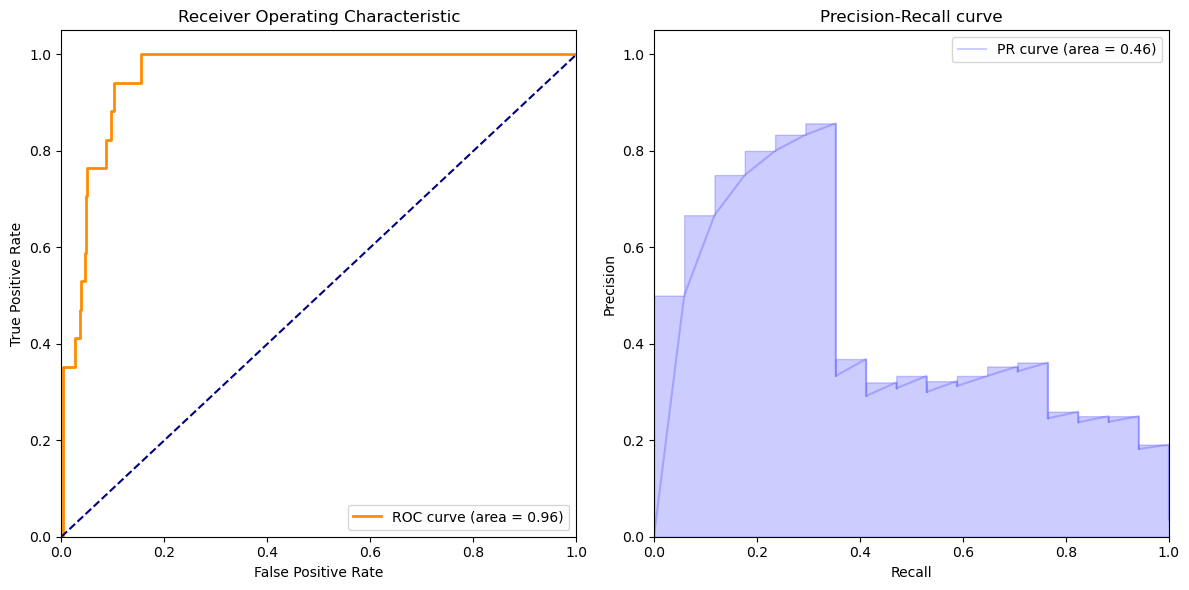

{'Precision': 0.21333333333333335,
 'Recall': 0.9411764705882353,
 'F1': 0.3478260869565218,
 'F1_macro': 0.6395881006864989,
 'ROC_AUC': 0.9563241605655137,
 'PR_AUC': 0.4558314120234358}

grid_cv.best_score_=0.626696604777903


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

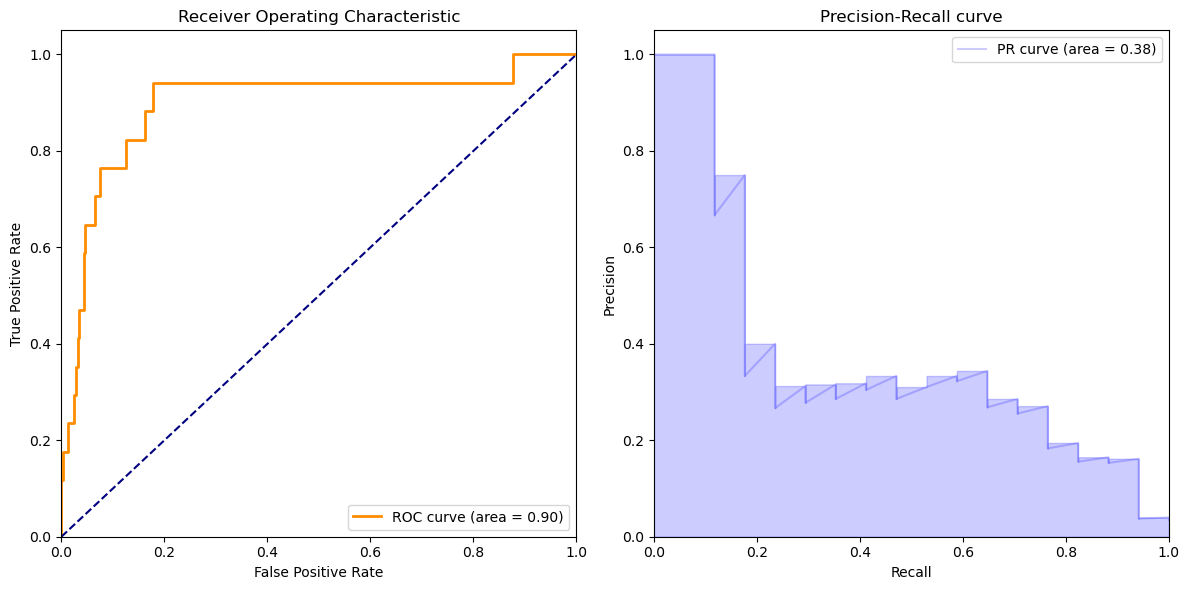

{'Precision': 0.20634920634920634,
 'Recall': 0.7647058823529411,
 'F1': 0.32499999999999996,
 'F1_macro': 0.6320259593679458,
 'ROC_AUC': 0.8972481696541277,
 'PR_AUC': 0.38438719290286333}

grid_cv.best_score_=0.61967929941015


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

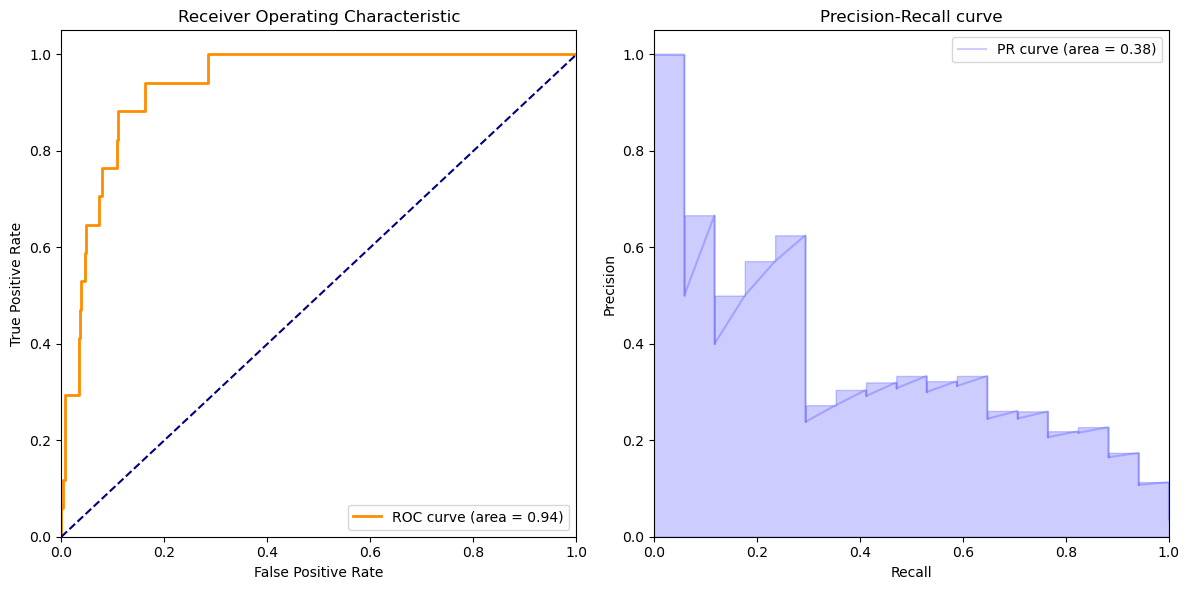

{'Precision': 0.1875,
 'Recall': 0.8823529411764706,
 'F1': 0.30927835051546393,
 'F1_macro': 0.6160891177203327,
 'ROC_AUC': 0.9367583943448624,
 'PR_AUC': 0.38256213635524333}

grid_cv.best_score_=0.6435454347366284


,random_state,best_parameters,metrics
0,0,"{'C': 1, 'l1_ratio': None, 'penalty': 'l1', 'solver': 'liblinear'}","{'Precision': 0.21333333333333335, 'Recall': 0.9411764705882353, 'F1': 0.3478260869565218, 'F1_macro': 0.6395881006864989, 'ROC_AUC': 0.9563241605655137, 'PR_AUC': 0.4558314120234358}"
1,25,"{'C': 10, 'l1_ratio': None, 'penalty': 'l1', 'solver': 'liblinear'}","{'Precision': 0.20634920634920634, 'Recall': 0.7647058823529411, 'F1': 0.32499999999999996, 'F1_macro': 0.6320259593679458, 'ROC_AUC': 0.8972481696541277, 'PR_AUC': 0.38438719290286333}"
2,42,"{'C': 0.1, 'l1_ratio': 0.75, 'penalty': 'elasticnet', 'solver': 'saga'}","{'Precision': 0.1875, 'Recall': 0.8823529411764706, 'F1': 0.30927835051546393, 'F1_macro': 0.6160891177203327, 'ROC_AUC': 0.9367583943448624, 'PR_AUC': 0.38256213635524333}"


In [11]:
for random_state in random_states:

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    X_train, X_test, y_train, y_test = train_test_split(X_global_train_scaled, y_global_train, test_size=0.2, random_state=random_state, stratify=y_global_train)
    
    model = LogisticRegression(random_state=random_state) 

    grid_cv = GridSearchCV(estimator=model, 
                           param_grid=hyperparameter_grid,
                           cv=skf,
                           verbose=0,
                           scoring='f1_macro'
                        ) 
    
    # execute the grid search
    grid_cv.fit(X_train, y_train)
    
    y_predict_proba = grid_cv.predict_proba(X_test)[:, 1]

    threshold = 0.05
    metrics = evaluate_model(y_test, y_predict_proba, threshold)
    display(metrics)

    print(f"{grid_cv.best_score_=}")
    
    if grid_cv.best_score_ > best_score:
        best_score = grid_cv.best_score_
        best_params = {
            'random_state': random_state,
            'C': grid_cv.best_params_['C'],
            'penalty': grid_cv.best_params_['penalty'],
            'solver': grid_cv.best_params_['solver'],
            'l1_ratio': grid_cv.best_params_['l1_ratio']
        }

    all_params_entry = {
        'random_state': random_state,
        'best_parameters': grid_cv.best_params_,
        'metrics': metrics
    }
    all_params.append(all_params_entry)

all_params_df = pd.DataFrame(all_params)
pd.set_option('display.max_colwidth', None)
display(all_params_df)

## D. Retrain the model with the best parameters on the whole dataset

In [12]:
final_model = LogisticRegression(random_state=best_params['random_state'],
                                 C=best_params['C'],
                                 penalty=best_params['penalty'],
                                 solver=best_params['solver'],
                                 l1_ratio=best_params['l1_ratio']
                                 )

final_model.fit(X_global_train_scaled, y_global_train)

LogisticRegression(C=0.1, l1_ratio=0.75, penalty='elasticnet', random_state=42,
                   solver='saga')

## C. Evaluate final model

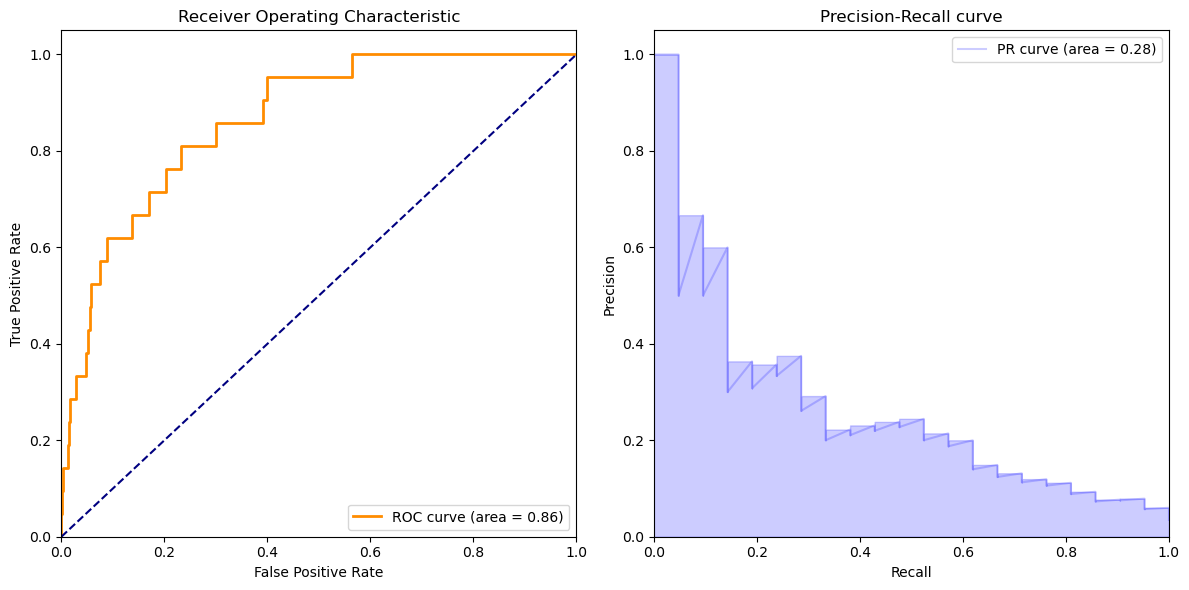

{'Precision': 0.09659090909090909,
 'Recall': 0.8095238095238095,
 'F1': 0.17258883248730963,
 'F1_macro': 0.5056811620398961,
 'ROC_AUC': 0.8641672792616188,
 'PR_AUC': 0.2773775390893012}

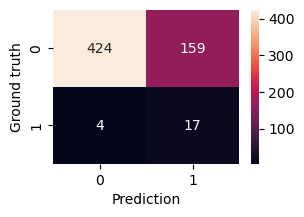

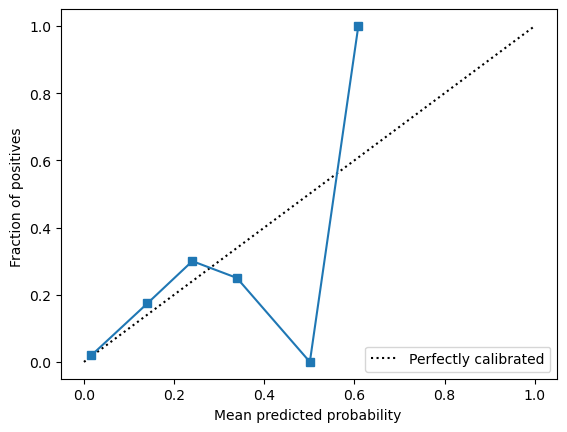

In [13]:
y_pred_proba = final_model.predict_proba(X_global_test_scaled)[:, 1]
threshold=0.02

metrics = evaluate_model(y_global_test, y_pred_proba, threshold)
display(metrics)

y_pred = (y_pred_proba >= threshold).astype(int)
cm = confusion_matrix(y_global_test, y_pred)
plt.figure(figsize = (3, 2))
f = sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Ground truth')
plt.xlabel('Prediction');

from sklearn.calibration import calibration_curve, CalibrationDisplay
prob_true, prob_pred = calibration_curve(y_global_test, y_pred_proba, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, y_global_test)
disp.plot()

### Probability distribution

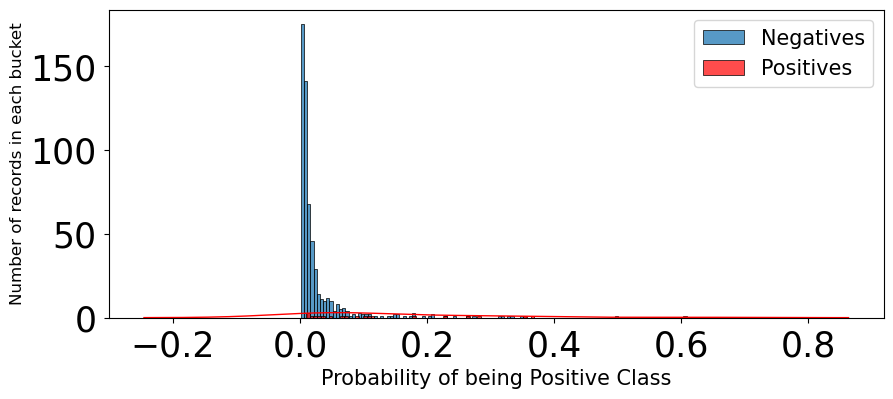

In [14]:
plt.figure(figsize=(10,4))
histogram_pos = sns.histplot(y_pred_proba[y_global_test==0], bins=100, label='Negatives')
histogram_pos = sns.histplot(y_pred_proba[y_global_test==1], bins=100, label='Positives', alpha=0.7, color='r')
density_curve_neg = sns.kdeplot(y_pred_proba[y_global_test==1], linewidth=1, color='r')
plt.xlabel('Probability of being Positive Class', fontsize=15)
plt.ylabel('Number of records in each bucket', fontsize=12)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show() 

### SHAP Values

In [15]:
explainer = shap.Explainer(final_model, X_global_train_scaled)
shap_values = explainer(X_global_test)


feature_importances["Coef"] = final_model.coef_.ravel()
feature_importances["Mean shap values"] = np.mean(np.abs(shap_values.values), axis=0)


In [16]:
feature_importances

,Coef,Mean shap values
Age,0.175760,10.989343
HBR (b),0.390322,29.091707
Systolic AP(b),-0.170773,22.690766
Creatinine in blood,0.277620,29.074225
EF Percentage,-0.727122,39.624757
White blood cells count,0.169131,1.932086
Glucose,0.278775,1.840768
CHF KiLLip_1.0,-0.215747,0.127634
CHF KiLLip_2.0,0.000000,0.000000
CHF KiLLip_3.0,0.016399,0.002606


In [17]:
def plot_weights(feature_importances, column1, column2, label1, label2, title, num_digits=3):
    plt.style.use('seaborn-v0_8-talk')  # Applying the style
    palette = sns.color_palette("husl", 2)  # Defining the color palette
    
    barWidth = 0.45

    r1 = np.arange(len(feature_importances[column1]))
    r2 = [x + barWidth for x in r1]

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # Create 1 row, 2 columns of subplots

    def add_values(ax, bars):
        for bar in bars:
            width = bar.get_width()
            if width >= 0:
                h_align = 'left'  # Horizontal alignment
                padding = 0.001  # Adjust this value to position the text to the right of the bar
            else:
                h_align = 'right' 
                padding = -0.000001  # Adjust this value to position the text to the left of the bar

            ax.text(width + padding,               
                    bar.get_y() + bar.get_height() / 2.5 ,  
                    f"{width :.{num_digits}f}",  
                    ha=h_align, va='center', fontsize=7)

    # Plot for column 1
    bars1 = axs[0].barh(r1, feature_importances[column1], color=palette[0], height=barWidth, edgecolor='grey', label=label1)
    axs[0].set_yticks(r1)
    axs[0].set_yticklabels(feature_importances.index, fontsize=10)
    axs[0].set_xlabel('Score', fontsize=12, fontweight='bold')
    axs[0].set_ylabel('Feature', fontsize=12, fontweight='bold')
    axs[0].grid(axis='x', linestyle='--', alpha=0.7)
    axs[0].legend()
    add_values(axs[0], bars1)  # Add values to the bars in the first subplot

    # Plot for column 2
    bars2 = axs[1].barh(r2, feature_importances[column2], color=palette[1], height=barWidth, edgecolor='grey', label=label2)
    axs[1].set_yticks(r2)
    axs[1].set_yticklabels(feature_importances.index, fontsize=10)
    axs[1].set_xlabel('Score', fontsize=12, fontweight='bold')
    axs[1].grid(axis='x', linestyle='--', alpha=0.7)
    axs[1].legend()
    add_values(axs[1], bars2)  # Add values to the bars in the second subplot

    # Set a common title
    plt.suptitle(title, fontsize=14, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust top to make room for the suptitle

    plt.show()

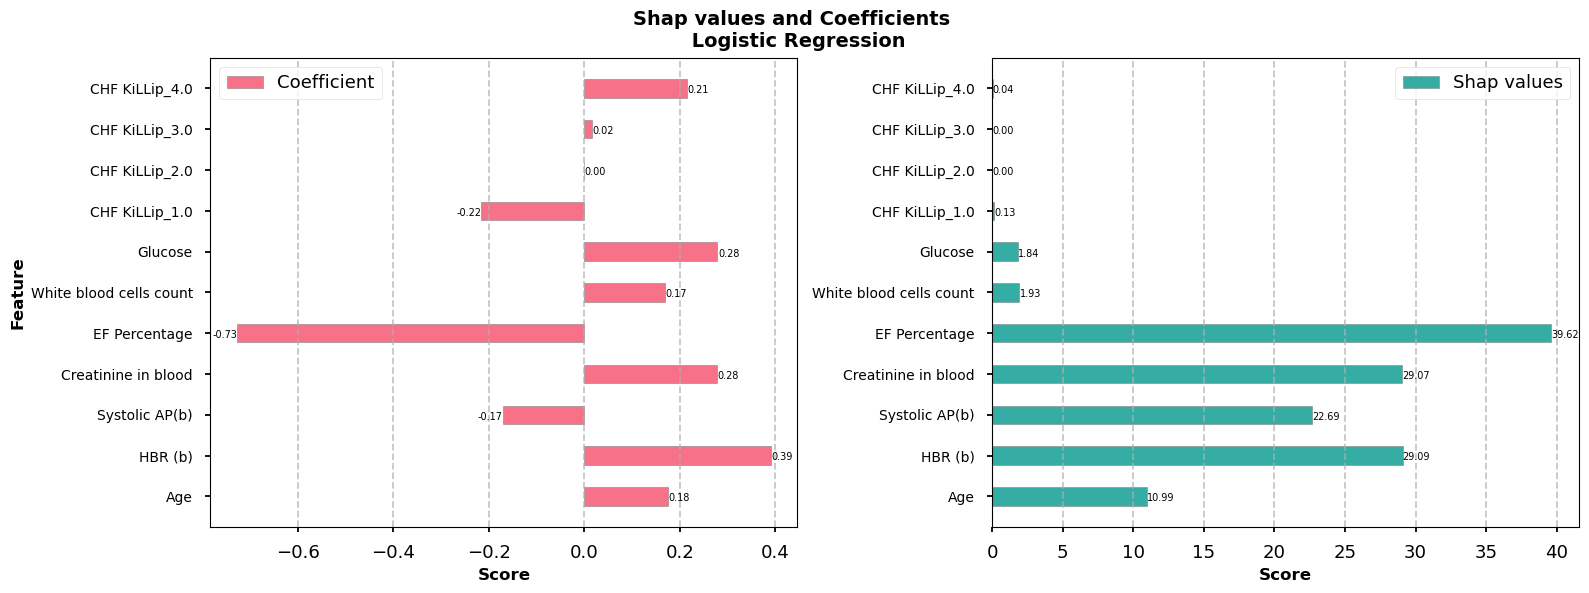

In [18]:
plot_weights(feature_importances, 
             'Coef',
             'Mean shap values', 
             label1='Coefficient', 
             label2='Shap values', 
             title='Shap values and Coefficients \n Logistic Regression', 
             num_digits = 2 )

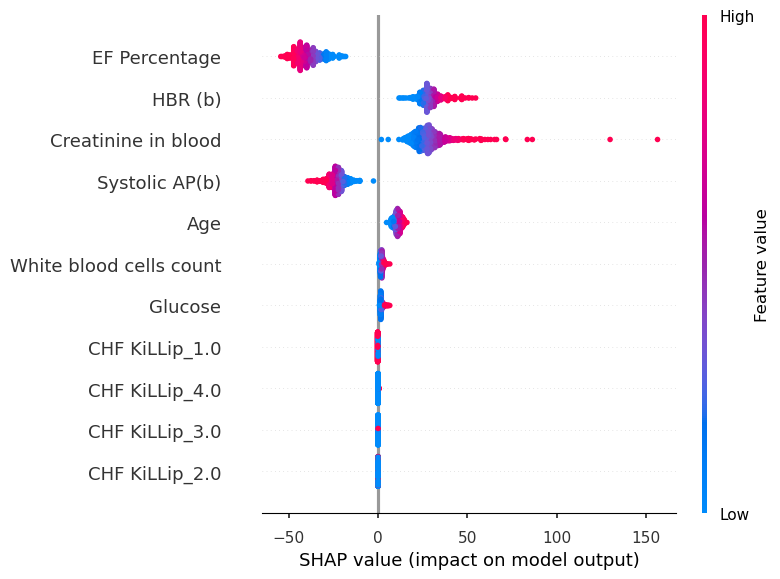

In [19]:
shap.summary_plot(shap_values.values, X_global_test_scaled, feature_names=feature_names, show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)